In [ ]:
#sudo apt-get install libopenslide0
#sudo apt update(for open cv)
#sudo apt install libgl1-mesa-glx((for open cv))


In [7]:
!pip install openslide-python

     |████████████████████████████████| 316 kB 9.0 MB/s eta 0:00:01
  Created wheel for openslide-python: filename=openslide_python-1.1.2-cp37-cp37m-linux_x86_64.whl size=28130 sha256=0d10406434f282dd650038e0aacebffbf9bf39502e3201ea419f2fffdc296729
  Stored in directory: /home/jupyter/.cache/pip/wheels/6f/c3/97/980962653f9305314bfb6d93f80be5e21f13e206af66fc7ad3
Successfully built openslide-python


In [10]:
!pip install tifffile

     |████████████████████████████████| 165 kB 7.5 MB/s eta 0:00:01


In [20]:
import cv2

In [1]:
# Data Science Imports
import pandas as pd
import numpy as np

# Microscopy Related Imports
import openslide
import tifffile

# Cloud Related Imports
from google.cloud import storage

# Visualization Imports
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from PIL import Image
import cv2

# Built In Imports
import os
import gc

# Utility Imports
from vis_utils import mass_visualization
from vis_utils import determine_local_label
from vis_utils import get_all_paths
from vis_utils import find_local_path
from vis_utils import return_path_dirs
from vis_utils import get_overlay_objects
from vis_utils import do_evaluation
from vis_utils import OverlayTool

In [ ]:
#gsutil cp gs://viz_test_bucket/Viz_Input_Test/SGN023_APD_ML1404011E_20200406_avb6_DF4000^1174423.svs .
#gs://viz_test_bucket/Viz_Input_Test/csv/SGN023_APD_ML1404011E_20200406_avb6_DF4000^1174423.csv .

In [79]:
# Create visualization output directory
##PATH_TO_OUTPUT_DIR = "/home/jupyter/viz_tutorial/output_visualizations"

PATH_TO_OUTPUT_DIR = "gs://viz_test_bucket/Viz_Output_Test"

if not os.path.isdir(PATH_TO_OUTPUT_DIR):
  #  os.makedirs(os.path.join(PATH_TO_OUTPUT_DIR, "gt", "slide_only"), exist_ok=True)
    os.makedirs(os.path.join(PATH_TO_OUTPUT_DIR, "edge", "slide_only"), exist_ok=True)
  #  os.makedirs(os.path.join(PATH_TO_OUTPUT_DIR, "gt", "color_maps"))
    os.makedirs(os.path.join(PATH_TO_OUTPUT_DIR, "edge", "color_maps"))

# Path to where prediction CSV's are contained
#PATH_TO_MAIN_CSV_DIR = "/home/jupyter/viz_tutorial/csvs/edge_preds"
#PATH_TO_GT_CSV_DIR = "/home/jupyter/viz_tutorial/csvs/gt_labels"

PATH_TO_MAIN_CSV_DIR = "/home/jupyter/csv/" 
ALL_CSV_PATHS =["/home/jupyter/csv/SGN023_APD_ML1404011E_20200406_avb6_DF4000^1174423.csv" ]
# Get paths to the original slides and the respective CSVs
#ALL_CSV_PATHS = [os.path.join(PATH_TO_MAIN_CSV_DIR, f_name) for f_name in os.listdir(PATH_TO_MAIN_CSV_DIR) if not ".ipyn" in f_name]
#ALL_GT_CSV_PATHS = [os.path.join(PATH_TO_GT_CSV_DIR, f_name) for f_name in os.listdir(PATH_TO_GT_CSV_DIR) if not ".ipyn" in f_name]
#ALL_PATHS = get_all_paths(list_of_dir_paths=return_path_dirs())

ALL_PATHS = ["/home/jupyter/SGN023_APD_ML1404011E_20200406_avb6_DF4000^1174423.svs"]

In [77]:
slide_name ="SGN023_APD_ML1404011E_20200406_avb6_DF4000^1174423.csv"

In [66]:
pred_csv_path = [path for path in ALL_CSV_PATHS if slide_name in path][0]

In [67]:
pred_df = pd.read_csv(pred_csv_path)
pred_df["preds"] = pred_df["preds"].apply(lambda x: x.lower().replace(" ", "_"))
pred_df["preds"] = pred_df["preds"].apply(lambda x: x.replace("necrotic", "exclusion"))

In [68]:
pred_df

,slide_name,slide_path,x_coords,y_coords,preds,confidence
0,SGN023_APD ML1404011E 20200406 avb6 DF4000^117...,gs://viz_test_bucket/Viz_Input_Test/SGN023_APD...,0,0,no_tissue,1.0
1,SGN023_APD ML1404011E 20200406 avb6 DF4000^117...,gs://viz_test_bucket/Viz_Input_Test/SGN023_APD...,0,1024,no_tissue,1.0
2,SGN023_APD ML1404011E 20200406 avb6 DF4000^117...,gs://viz_test_bucket/Viz_Input_Test/SGN023_APD...,0,2048,no_tissue,1.0
3,SGN023_APD ML1404011E 20200406 avb6 DF4000^117...,gs://viz_test_bucket/Viz_Input_Test/SGN023_APD...,0,3072,no_tissue,1.0
4,SGN023_APD ML1404011E 20200406 avb6 DF4000^117...,gs://viz_test_bucket/Viz_Input_Test/SGN023_APD...,0,4096,no_tissue,1.0
...,...,...,...,...,...,...
865,SGN023_APD ML1404011E 20200406 avb6 DF4000^117...,gs://viz_test_bucket/Viz_Input_Test/SGN023_APD...,29696,24576,no_tissue,1.0
866,SGN023_APD ML1404011E 20200406 avb6 DF4000^117...,gs://viz_test_bucket/Viz_Input_Test/SGN023_APD...,29696,25600,no_tissue,1.0
867,SGN023_APD ML1404011E 20200406 avb6 DF4000^117...,gs://viz_test_bucket/Viz_Input_Test/SGN023_APD...,29696,26624,no_tissue,1.0
868,SGN023_APD ML1404011E 20200406 avb6 DF4000^117...,gs://viz_test_bucket/Viz_Input_Test/SGN023_APD...,29696,27648,no_tissue,1.0


In [69]:
path_to_slide_on_machine = find_local_path(pred_csv_path[:-4].rsplit("/", 1)[1], ALL_PATHS)

In [74]:
path_to_slide_on_machine ='/home/jupyter/SGN023_APD_ML1404011E_20200406_avb6_DF4000^1174423.svs'

In [71]:
pred_df.drop(columns=["slide_path"], inplace=True)

In [75]:
 pred_overlay = OverlayTool(pred_df, PATH_TO_OUTPUT_DIR, path_to_slide_on_machine)

In [80]:
edge_pred_tool, gt_label_tool = get_overlay_objects(
   # slide_name=ALL_GT_CSV_PATHS[2].rsplit("/", 1)[1], 
    #slide_name=ALL_GT_CSV_PATHS[2].rsplit("/", 1)[1], 
   # slide_name=ALL_CSV_PATHS[2].rsplit("/", 1)[1], 
    slide_name ="SGN023_APD_ML1404011E_20200406_avb6_DF4000^1174423.csv",
    all_csv_paths=ALL_CSV_PATHS, 
    all_slide_paths=ALL_PATHS,
    output_dir=PATH_TO_OUTPUT_DIR, 
    return_label_object=True
)

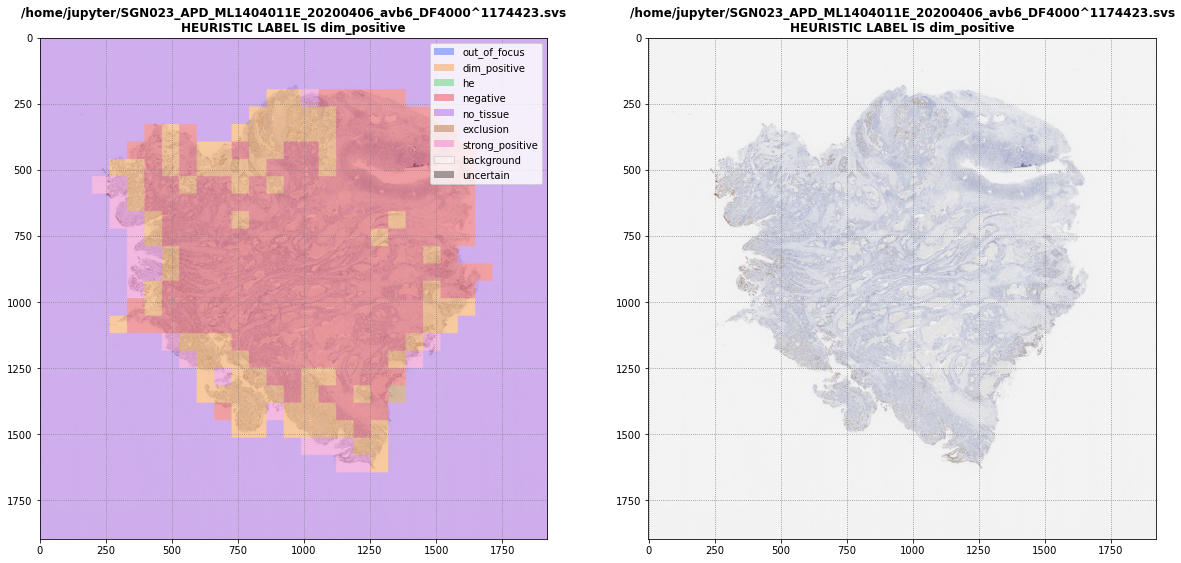

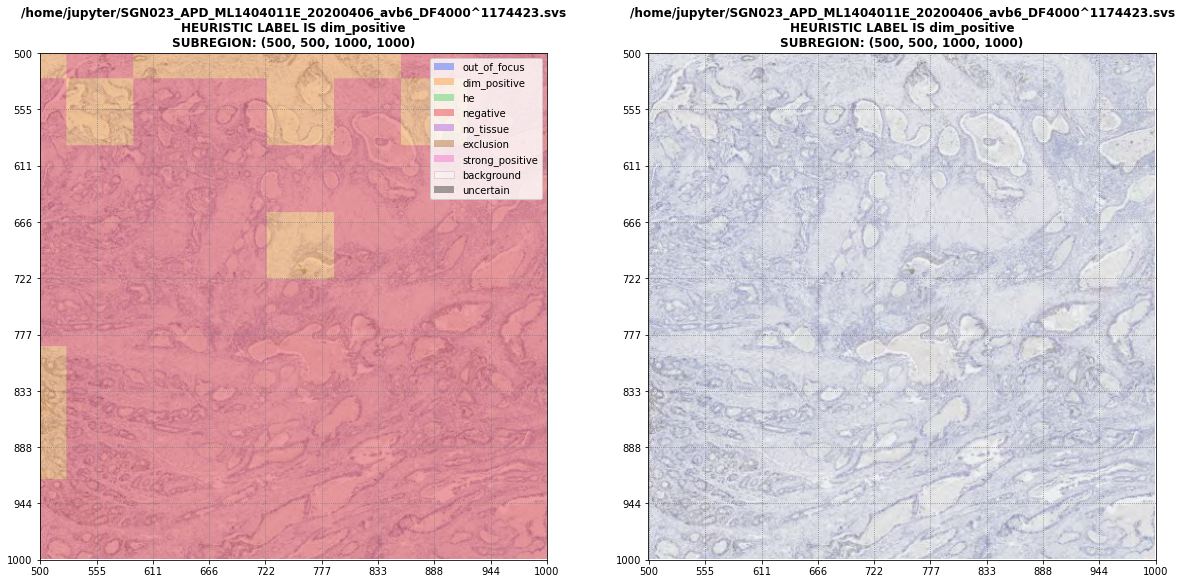

In [81]:
#gt_label_tool.plot_side_by_side()
edge_pred_tool.plot_side_by_side()

#gt_label_tool.plot_side_by_side(subregion=(500,500,1000,1000))
edge_pred_tool.plot_side_by_side(subregion=(500,500,1000,1000))

In [82]:
slide_prediction_df

NameError: name 'slide_prediction_df' is not defined

<br>

<a style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #ffffff; color: navy;" id="evaluate">3&nbsp;&nbsp;EVALUATE</a>

In [10]:
if os.path.isfile("/home/jupyter/viz_tutorial/slide_prediction_df.csv"):
    slide_prediction_df = pd.read_csv("/home/jupyter/viz_tutorial/slide_prediction_df.csv", index_col="Unnamed: 0")
else:   
    slide_prediction_df = do_evaluation(ALL_CSV_PATHS, ALL_PATHS)
display(slide_prediction_df.head())

,out_of_focus,dim_positive,he,negative,no_tissue,exclusion,strong_positive,heuristic_pred,folder_gt_label,heuristic_binary_pred,folder_binary_gt_label
/home/jupyter/viz_tutorial/csvs/edge_preds/SGN010B_APD ML1808782 20191025 CD228 DF4000^1116958.csv,0.0,0.121324,0.0,0.003676,0.725806,0.011029,0.863971,strong_positive,strong_positive,GOOD,GOOD
/home/jupyter/viz_tutorial/csvs/edge_preds/SGN023_APD ML0911177B 20200423 avb6 ^1187084.csv,0.0,0.326316,0.0,0.052632,0.670139,0.000000,0.621053,strong_positive,strong_positive,GOOD,GOOD
/home/jupyter/viz_tutorial/csvs/edge_preds/SGN010B_APD ML1710353B 20191108 CD228 ^1132898.csv,0.0,0.106061,0.0,0.045455,0.788462,0.053030,0.795455,strong_positive,strong_positive,GOOD,GOOD
/home/jupyter/viz_tutorial/csvs/edge_preds/SGN010B_APD ML1703166 20191105 CD228 ^1120968.csv,0.0,0.064000,0.0,0.936000,0.743852,0.000000,0.000000,negative,negative,GOOD,GOOD
/home/jupyter/viz_tutorial/csvs/edge_preds/SGN023_APD MPB02435G 20200406 avb6 NCR DF4000^1174448.csv,0.0,0.000000,0.0,1.000000,0.627778,0.000000,0.000000,negative,negative,GOOD,GOOD


In [47]:
missed_files = list(slide_prediction_df[slide_prediction_df.heuristic_pred!=slide_prediction_df.folder_gt_label].index.values)

# See which files we missed
print("MISSED FILES:")
for i, f in enumerate(missed_files): print(f"\t{i+1}. {f}")

MISSED FILES:
	1. /home/jupyter/viz_tutorial/csvs/edge_preds/SGN010B_APD ML1804532B 20191113 CD228 ^1131905.csv
	2. /home/jupyter/viz_tutorial/csvs/edge_preds/SGN010B_APD ML1703654A 20191112 CD228 ^1131969.csv
	3. /home/jupyter/viz_tutorial/csvs/edge_preds/SGN010B_APD ML1609222C 20191113 CD228 ^1131894.csv
	4. /home/jupyter/viz_tutorial/csvs/edge_preds/SGN010B_APD ML1007128A 20191217 CD228 ^1142646.csv
	5. /home/jupyter/viz_tutorial/csvs/edge_preds/89_F00052553_HER2.csv
	6. /home/jupyter/viz_tutorial/csvs/edge_preds/SGN010B_APD ML1701882B 20191112 CD228 ^1131964.csv
	7. /home/jupyter/viz_tutorial/csvs/edge_preds/73_F00052530_HER2_neg.csv
	8. /home/jupyter/viz_tutorial/csvs/edge_preds/SGN010B_APD ML1108271B 20191217 CD228 ^1142644.csv


<br>

<a style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #ffffff; color: navy;" id="mass_viz">4&nbsp;&nbsp;MASS VISUALIZATION</a>

In [ ]:
mass_visualization(list_of_names=missed_files, plot_size=1280, all_csv_paths=ALL_CSV_PATHS, all_slide_paths=ALL_PATHS, show_frac_map=True, style="side_by_side")